In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [184]:
Bankdata = pd.read_csv(r'C:\Users\ENVY\OneDrive\Documents\termdeposit_train.csv')

In [185]:
# Explore the dataset
print(Bankdata.head())
print(Bankdata.info())

      ID  age         job   marital  education default  balance housing loan  \
0  26110   56      admin.   married    unknown      no     1933      no   no   
1  40576   31     unknown   married  secondary      no        3      no   no   
2  15320   27    services   married  secondary      no      891     yes   no   
3  43962   57  management  divorced   tertiary      no     3287      no   no   
4  29842   31  technician   married  secondary      no      119     yes   no   

     contact  day month  duration  campaign  pdays  previous poutcome  \
0  telephone   19   nov        44         2     -1         0  unknown   
1   cellular   20   jul        91         2     -1         0  unknown   
2   cellular   18   jul       240         1     -1         0  unknown   
3   cellular   22   jun       867         1     84         3  success   
4   cellular    4   feb       380         1     -1         0  unknown   

  subscribed  
0         no  
1         no  
2         no  
3        yes  
4    

In [186]:
Bankdata['OUTPUT_LABEL'] = (Bankdata.subscribed == 'yes').astype('int')

In [187]:
Bankdata[list(Bankdata.columns)[:10]].head()

,ID,age,job,marital,education,default,balance,housing,loan,contact
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone
1,40576,31,unknown,married,secondary,no,3,no,no,cellular
2,15320,27,services,married,secondary,no,891,yes,no,cellular
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular
4,29842,31,technician,married,secondary,no,119,yes,no,cellular


In [188]:
Bankdata[list(Bankdata.columns)[10:]].head()

,day,month,duration,campaign,pdays,previous,poutcome,subscribed,OUTPUT_LABEL
0,19,nov,44,2,-1,0,unknown,no,0
1,20,jul,91,2,-1,0,unknown,no,0
2,18,jul,240,1,-1,0,unknown,no,0
3,22,jun,867,1,84,3,success,yes,1
4,4,feb,380,1,-1,0,unknown,no,0


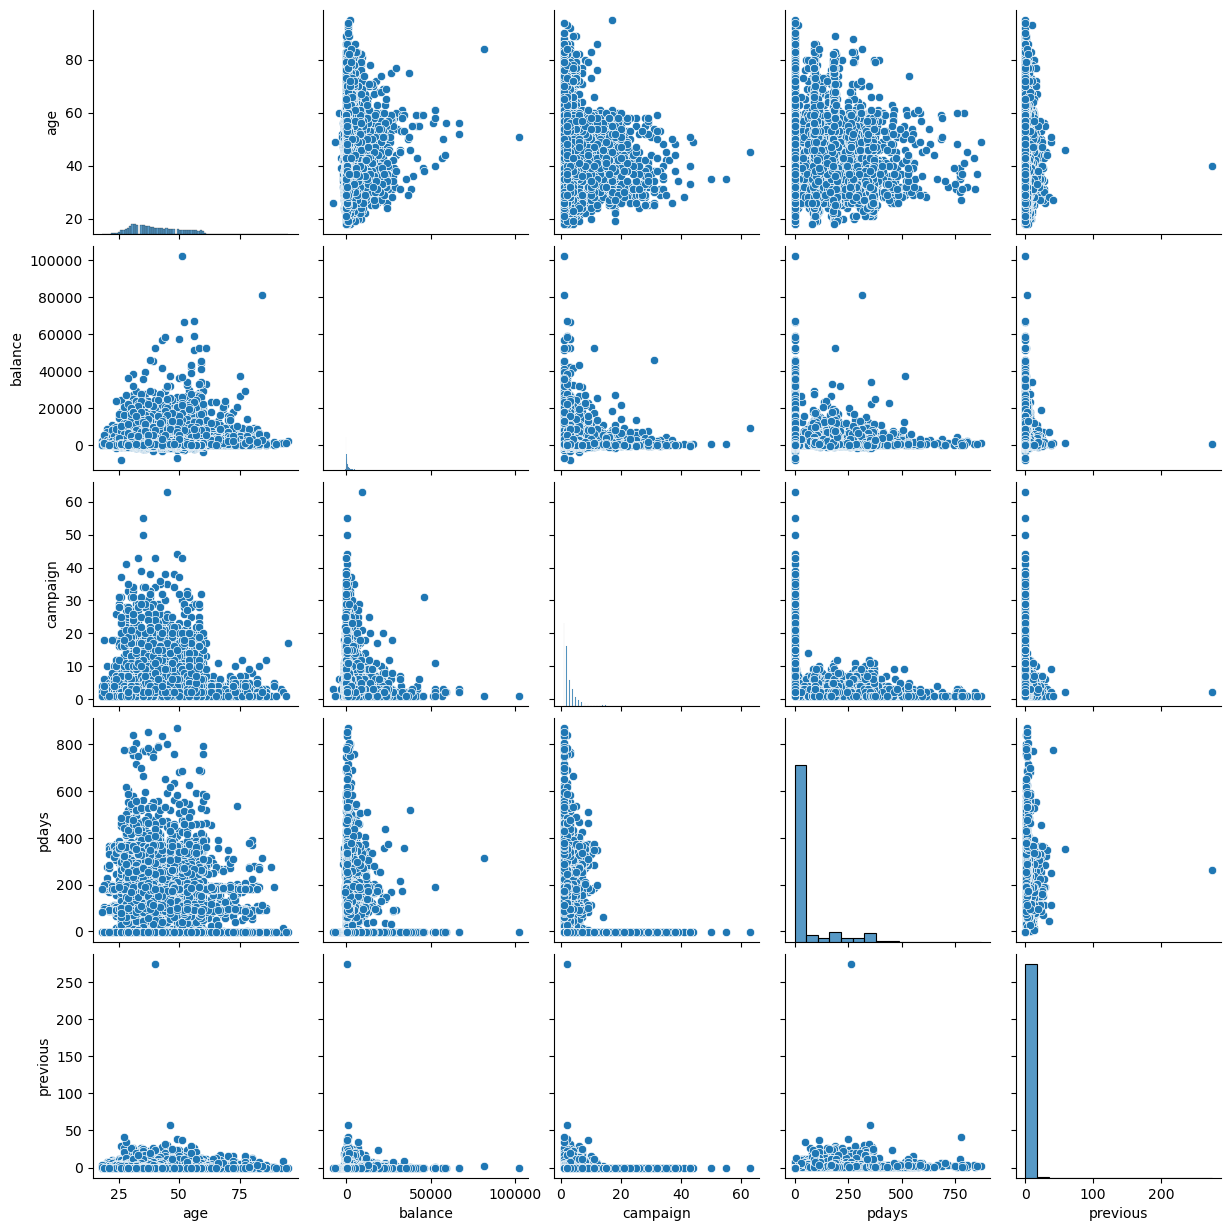

In [189]:
# Define numerical and categorical features
cols_num = ['age', 'balance', 'campaign', 'pdays', 'previous']
cols_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Visualize numerical features
sns.pairplot(Bankdata[cols_num])
plt.show()

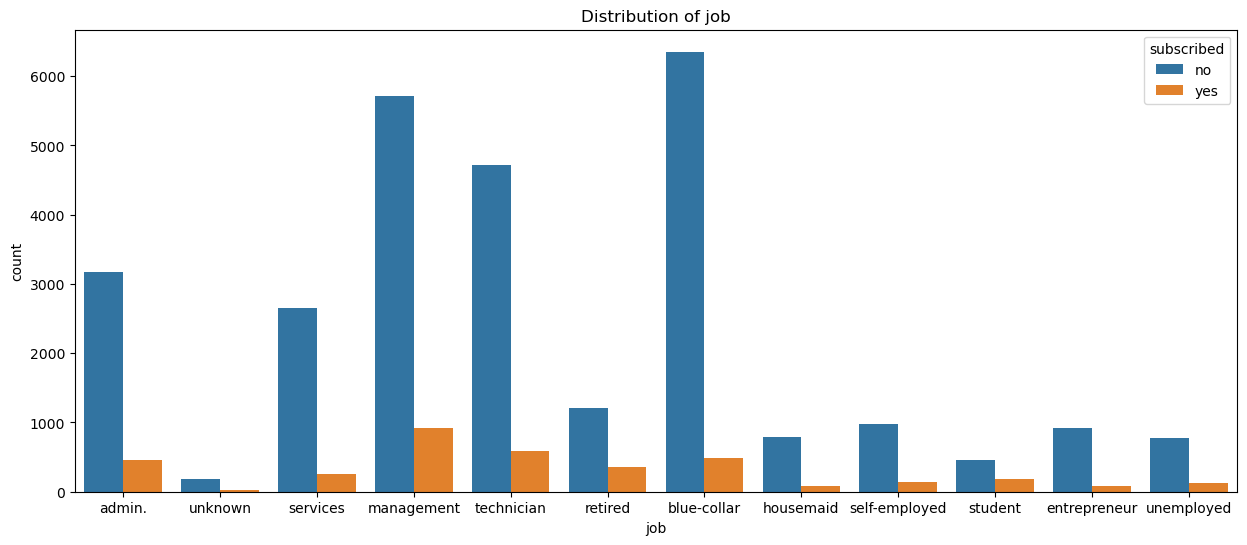

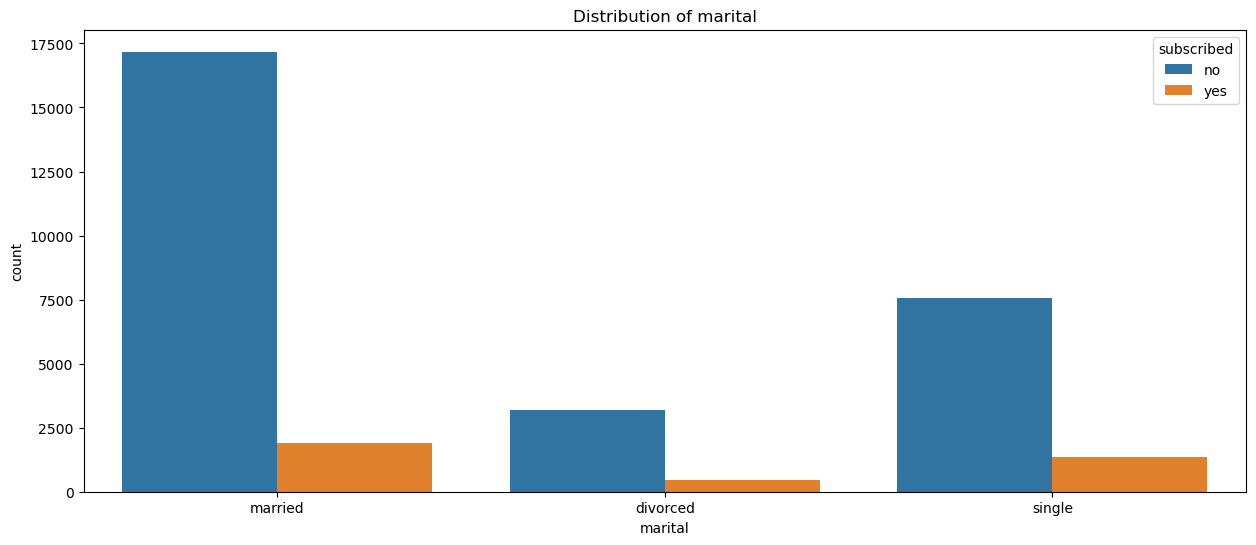

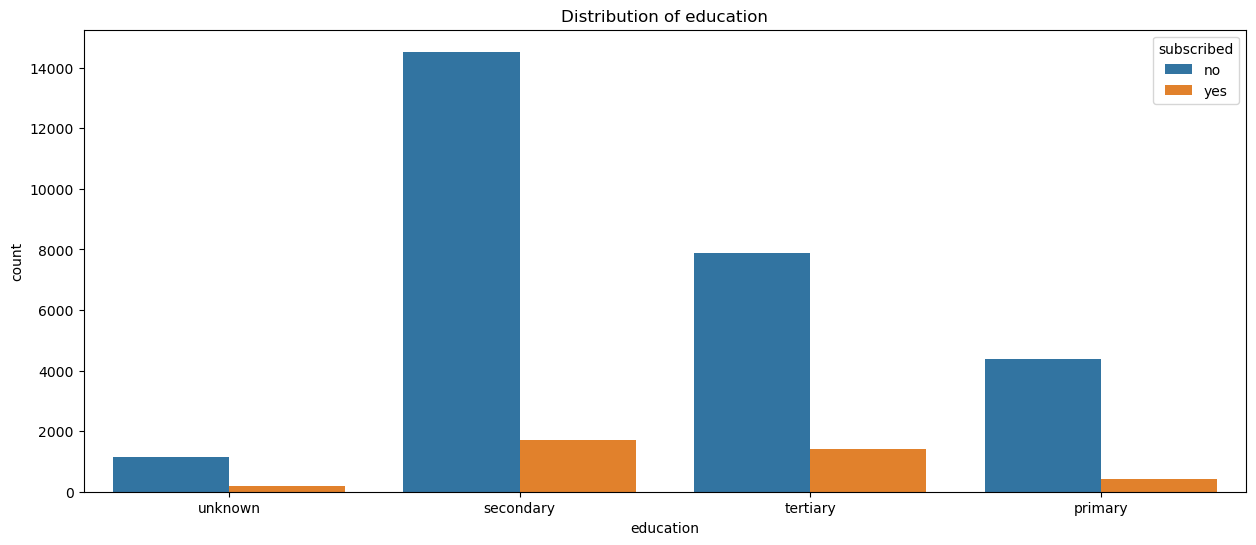

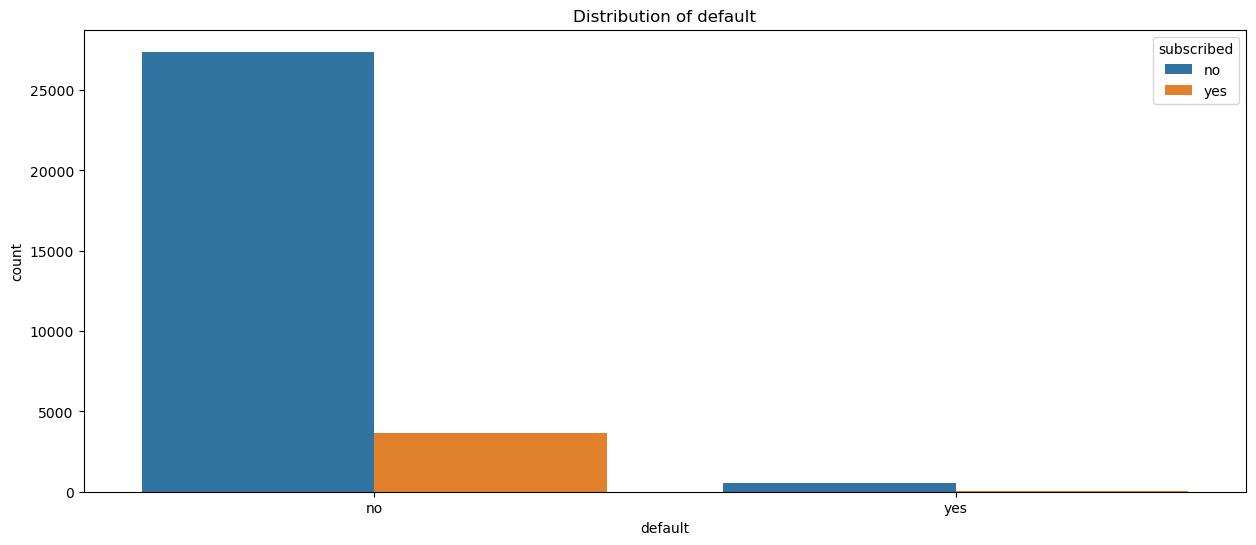

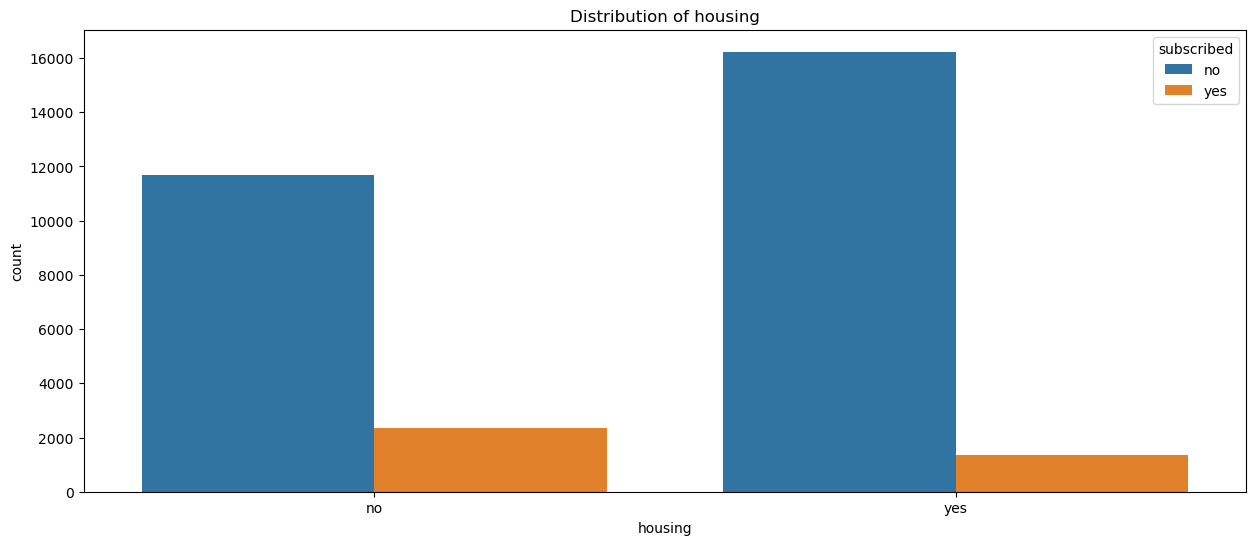

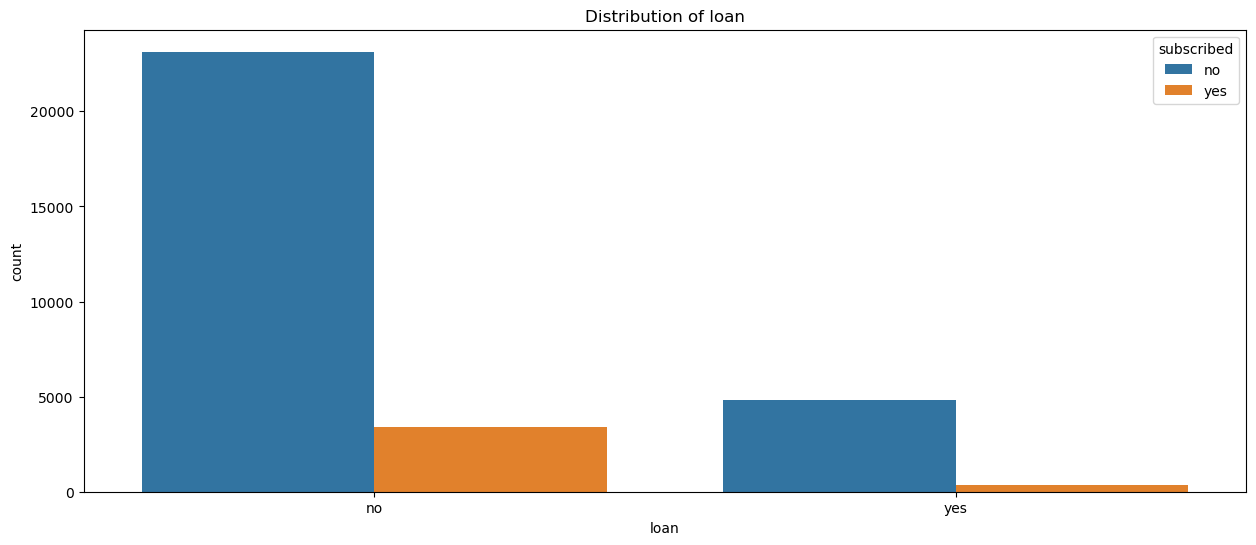

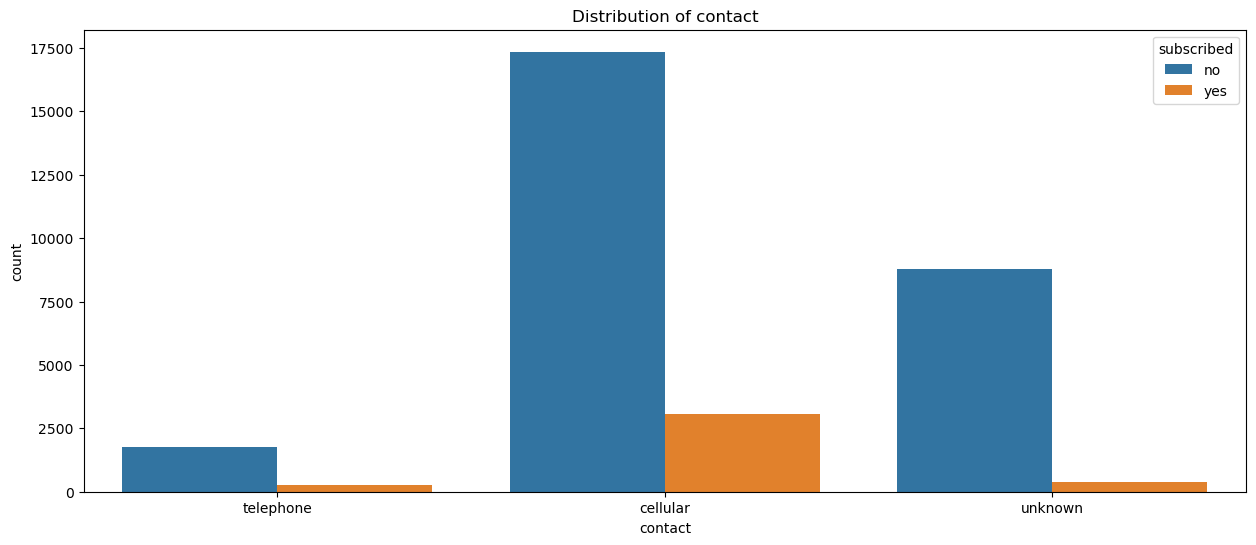

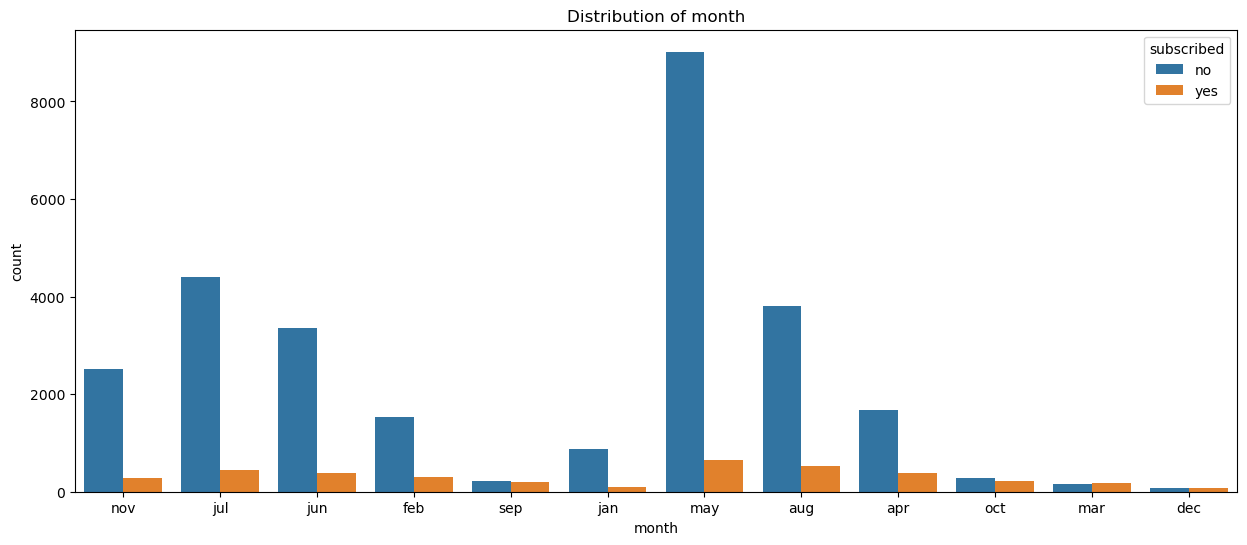

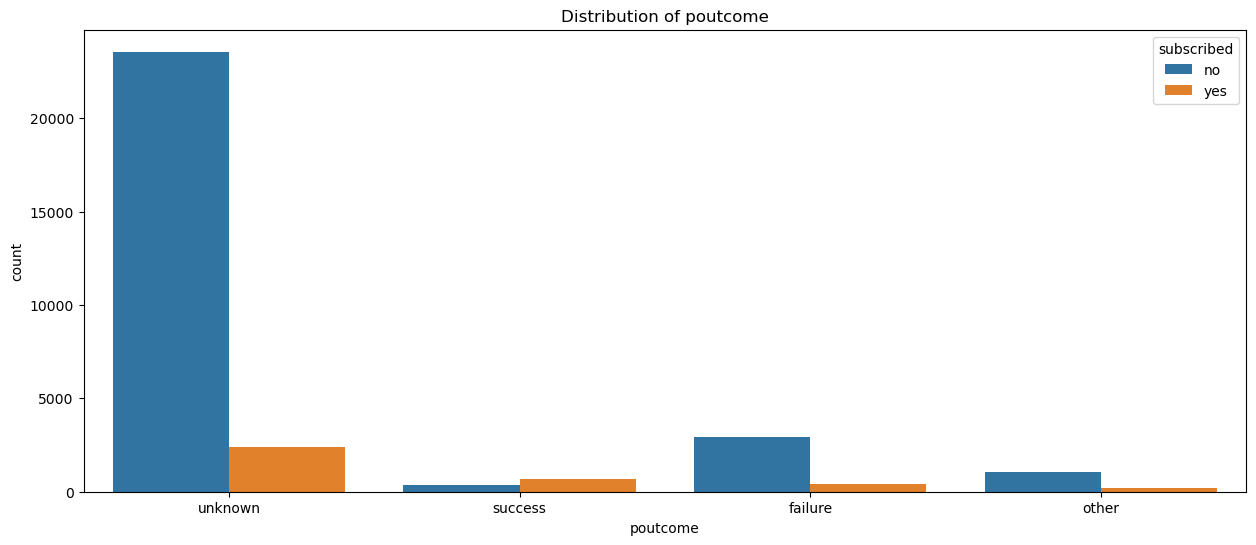

In [190]:
# Visualize categorical features
for col in cols_cat:
    plt.figure(figsize=(15, 6))
    sns.countplot(x=col, data=Bankdata, hue='subscribed')
    plt.title(f'Distribution of {col}')
    plt.show()

In [191]:
# Preprocess categorical features using one-hot encoding
cols_new_cat = pd.get_dummies(Bankdata[cols_cat], drop_first=False)
Bankdata = pd.concat([Bankdata, cols_new_cat], axis=1)
Bankdata.drop(cols_cat, axis=1, inplace=True)

In [192]:
# Define input columns
cols_input = cols_num + list(cols_new_cat.columns)

In [193]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(Bankdata[cols_input], Bankdata['subscribed'],
                                                      test_size=0.2, random_state=42)

In [194]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[cols_num])
X_valid_scaled = scaler.transform(X_valid[cols_num])

In [195]:
# Combine scaled numerical features with one-hot encoded categorical features
X_train_processed = np.concatenate([X_train_scaled, X_train[cols_new_cat.columns].values], axis=1)
X_valid_processed = np.concatenate([X_valid_scaled, X_valid[cols_new_cat.columns].values], axis=1)

In [196]:
# Train a K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_processed, y_train)

KNeighborsClassifier(n_neighbors=100)

In [197]:
def calc_specificity(y_actual, y_pred, thresh):
    # Calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('AUC:%.3f' % auc)
    print('Accuracy:%.3f' % accuracy)
    print('Recall:%.3f' % recall)
    print('Precision:%.3f' % precision)
    print('Specificity:%.3f' % specificity)
    print('Prevalence:%.3f' % np.mean(y_actual))
    print('F1 Score:%.3f' % f1)
    print('')

# Assuming 'yes' corresponds to True and 'no' corresponds to False
y_train_bool = (y_train == 'yes')
y_valid_bool = (y_valid == 'yes')

# Create and fit the StandardScaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the training and validation sets
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_tf, y_train_bool)

# Evaluate the KNN model on training and validation sets
print('K-Nearest Neighbors Model Evaluation:')
print('Training:')
y_train_preds_knn = knn_model.predict_proba(X_train_tf)[:, 1]
print_report(y_train_bool, y_train_preds_knn, 0.5)

print('Validation:')
y_valid_preds_knn = knn_model.predict_proba(X_valid_tf)[:, 1]
print_report(y_valid_bool, y_valid_preds_knn, 0.5)

K-Nearest Neighbors Model Evaluation:
Training:
AUC:0.791
Accuracy:0.891
Recall:0.169
Precision:0.646
Specificity:0.987
Prevalence:0.118
F1 Score:0.267

Validation:
AUC:0.767
Accuracy:0.892
Recall:0.166
Precision:0.617
Specificity:0.986
Prevalence:0.115
F1 Score:0.261



In [198]:
# Train a Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_processed, y_train)

C:\Users\ENVY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [199]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf, y_train)

# Convert target variables to binary
y_train_binary = (y_train == 'yes').astype(int)
y_valid_binary = (y_valid == 'yes').astype(int)

# Evaluate the Logistic Regression model on training and validation sets
print('Logistic Regression Model Evaluation:')
print('Training:')
y_train_preds_lr = lr.predict_proba(X_train_tf)[:, 1]
_ = print_report(y_train_binary, y_train_preds_lr, 0.5)

print('Validation:')
y_valid_preds_lr = lr.predict_proba(X_valid_tf)[:, 1]
_ = print_report(y_valid_binary, y_valid_preds_lr, 0.5)

Logistic Regression Model Evaluation:
Training:
AUC:0.770
Accuracy:0.892
Recall:0.186
Precision:0.646
Specificity:0.986
Prevalence:0.118
F1 Score:0.289

Validation:
AUC:0.766
Accuracy:0.894
Recall:0.190
Precision:0.644
Specificity:0.986
Prevalence:0.115
F1 Score:0.294



In [208]:
# Save the scaler and models for future use
pickle.dump(scaler, open('scaler.sav', 'wb'))
pickle.dump(knn_model, open('knn_model.sav', 'wb'))
pickle.dump(lr_model, open('lr_model.sav', 'wb'))
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

In [209]:
# Test the models with sample data
sample_data = pd.read_csv(r'C:\Users\ENVY\OneDrive\Documents\termdeposit_test.csv')

In [210]:
# Use get_dummies for one-hot encoding
cols_new_cat_test = pd.get_dummies(sample_data[cols_cat], drop_first=False)

# Concatenate the one-hot encoded columns with the original DataFrame
sample_data = pd.concat([sample_data, cols_new_cat_test], axis=1)

# Drop the original categorical columns if needed
sample_data.drop(cols_cat, axis=1, inplace=True)

In [211]:
# Load the column names used for training
cols_input = pickle.load(open('cols_input.sav', 'rb'))

In [212]:
df_test_mean = sample_data[cols_input].mean(axis=0)
df_test_mean.to_csv('df_test_mean.csv', index=True)

In [213]:
df_mean_in = pd.read_csv('df_test_mean.csv', names=['col', 'mean_val'])

In [214]:
# Load the scaler used for standardization
scaler = pickle.load(open('scaler.sav', 'rb'))

# Function to fill missing values
def fill_my_missing(df, df_mean, col2use):
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c, 'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [215]:
# Function to calculate specificity
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

In [216]:
# Function to print evaluation metrics
def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = 2 * (precision * recall) / (precision + recall)

    print('AUC:%.3f' % auc)
    print('accuracy:%.3f' % accuracy)
    print('recall:%.3f' % recall)
    print('precision:%.3f' % precision)
    print('specificity:%.3f' % specificity)
    print('prevalence:%.3f' % calc_prevalence(y_actual))
    print('f1:%.3f' % f1)
    print(' ')

In [217]:
# Impute missing values in the sample data
sample_data = fill_my_missing(sample_data, df_mean_in, cols_input)

# Separate features and target variable
X_sample = sample_data[cols_input].values

# Standardize the sample data
X_sample_tf = scaler.transform(X_sample)

C:\Users\ENVY\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [219]:
# Load and test the KNN model
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tf, y_train)
print('K-Nearest Neighbors Model Evaluation:')
print('Sample Data:')
y_sample_preds_knn = knn.predict_proba(X_sample_tf)[:, 1]
print('Predicted Probabilities (KNN):', y_sample_preds_knn)

K-Nearest Neighbors Model Evaluation:
Sample Data:
Predicted Probabilities (KNN): [0.08 0.18 0.08 ... 0.08 0.52 0.1 ]


In [220]:
# Load and test the Logistic Regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf, y_train)
print('Logistic Regression Model Evaluation:')
print('Sample Data:')
y_sample_preds_lr = lr.predict_proba(X_sample_tf)[:, 1]
print('Predicted Probabilities (Logistic Regression):', y_sample_preds_lr)

Logistic Regression Model Evaluation:
Sample Data:
Predicted Probabilities (Logistic Regression): [0.05684028 0.17828671 0.04010559 ... 0.06783375 0.55597756 0.09477386]


In [221]:
# Assuming 0.5 as the threshold
threshold = 0.5

# Convert predicted probabilities to binary predictions
y_sample_preds_knn_binary = (y_sample_preds_knn >= threshold).astype(int)
y_sample_preds_lr_binary = (y_sample_preds_lr >= threshold).astype(int)

# Display the binary predictions
print('K-Nearest Neighbors Binary Predictions:', y_sample_preds_knn_binary)
print('Logistic Regression Binary Predictions:', y_sample_preds_lr_binary)

K-Nearest Neighbors Binary Predictions: [0 0 0 ... 0 1 0]
Logistic Regression Binary Predictions: [0 0 0 ... 0 1 0]
